In [55]:
# !pip install pytorch_lightning
# !pip install tensorboardX

In [1]:
from collections import namedtuple

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

import tqdm
import json
import sklearn.metrics as sm

import tensorboardX as tb
import tensorflow as tf
import datetime, os

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(31337)

## Create pairs (first track, subsequent track, time)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
DATA_DIR = "../input/mobod-dataset/"

In [4]:
data = pd.read_json(DATA_DIR + "data.json", lines=True)

In [5]:
data.head()

,message,timestamp,user,track,time,latency,recommendation,experiments
0,last,2022-06-13 11:39:37.645,4013,18934,0.02,0.000206,NaN,"{'AA': 'T1', 'COLLABORATIVE': 'T1'}"
1,next,2022-06-13 11:39:37.683,9693,29738,1.00,0.000902,3079.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"
2,next,2022-06-13 11:39:37.692,9693,3079,0.06,0.000923,20078.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"
3,next,2022-06-13 11:39:37.700,9693,20078,1.00,0.000858,12044.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"
4,next,2022-06-13 11:39:37.708,9693,12044,0.00,0.000927,37424.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"


In [6]:
Pair = namedtuple("Session", ["user", "start", "track", "time"])

def get_pairs(user_data):
    pairs = []
    first = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if first is None:
            first = row["track"]
        else:
            pairs.append(Pair(row["user"], first, row["track"], row["time"]))
        
        if row["message"] == "last":
            first = None
    return pairs

In [7]:
pairs = pd.DataFrame(
    data
    .groupby("user")
    .apply(get_pairs)
    .explode()
    .values
    .tolist(),
    columns=["user", "start", "track", "time"]
)

In [8]:
pairs

,user,start,track,time
0,0,2999,5089,0.00
1,0,2999,5992,0.00
2,0,2999,7960,0.00
3,0,2999,1725,0.00
4,0,2999,2606,0.00
...,...,...,...,...
715239,9999,44241,1491,0.00
715240,9999,44241,2580,0.02
715241,9999,44241,7960,0.25
715242,9999,44241,5372,0.00


In [9]:
track_meta = pd.read_json(DATA_DIR + "tracks.json", lines=True)
track_meta[track_meta['track']==5089]

,artist,title,track
5089,Linkin Park,What I've Done (Album Version),5089


In [10]:
pairs = pd.merge(pairs, track_meta[["artist", "track"]].rename(columns = {"artist": "artist_start", "track": "start"}), 
                 on='start', how='left')
pairs

,user,start,track,time,artist_start
0,0,2999,5089,0.00,Bløf
1,0,2999,5992,0.00,Bløf
2,0,2999,7960,0.00,Bløf
3,0,2999,1725,0.00,Bløf
4,0,2999,2606,0.00,Bløf
...,...,...,...,...,...
715239,9999,44241,1491,0.00,Live
715240,9999,44241,2580,0.02,Live
715241,9999,44241,7960,0.25,Live
715242,9999,44241,5372,0.00,Live


In [11]:
pairs = pd.merge(pairs, track_meta[["artist", "track"]].rename(columns = {"artist": "artist_track"}), 
                 on='track', how='left')
pairs

,user,start,track,time,artist_start,artist_track
0,0,2999,5089,0.00,Bløf,Linkin Park
1,0,2999,5992,0.00,Bløf,Nelly / Lincoln University Vocal Ensemble
2,0,2999,7960,0.00,Bløf,Faith No More
3,0,2999,1725,0.00,Bløf,Creedence Clearwater Revival
4,0,2999,2606,0.00,Bløf,Matt Costa
...,...,...,...,...,...,...
715239,9999,44241,1491,0.00,Live,Justin Bieber
715240,9999,44241,2580,0.02,Live,Joshua Radin
715241,9999,44241,7960,0.25,Live,Faith No More
715242,9999,44241,5372,0.00,Live,Jorge Drexler


In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(list(pairs["artist_start"]) + list(pairs["artist_track"]))
pairs["artist_start_le"] = le.transform(pairs["artist_start"])
pairs["artist_track_le"] = le.transform(pairs["artist_track"])

In [13]:
pairs

,user,start,track,time,artist_start,artist_track,artist_start_le,artist_track_le
0,0,2999,5089,0.00,Bløf,Linkin Park,581,2685
1,0,2999,5992,0.00,Bløf,Nelly / Lincoln University Vocal Ensemble,581,3266
2,0,2999,7960,0.00,Bløf,Faith No More,581,1597
3,0,2999,1725,0.00,Bløf,Creedence Clearwater Revival,581,1057
4,0,2999,2606,0.00,Bløf,Matt Costa,581,2967
...,...,...,...,...,...,...,...,...
715239,9999,44241,1491,0.00,Live,Justin Bieber,2716,2376
715240,9999,44241,2580,0.02,Live,Joshua Radin,2716,2331
715241,9999,44241,7960,0.25,Live,Faith No More,2716,1597
715242,9999,44241,5372,0.00,Live,Jorge Drexler,2716,2317


In [14]:
len(le.classes_)

5269

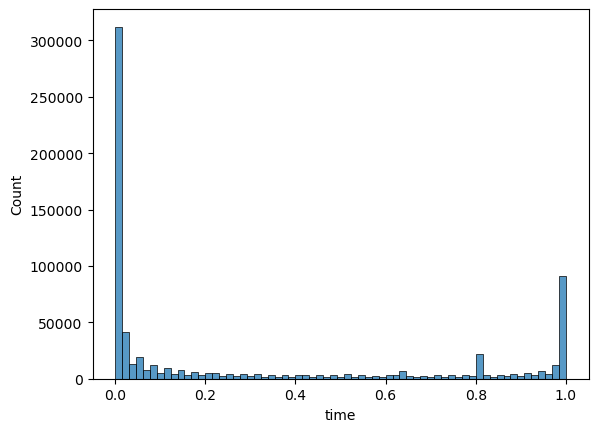

In [15]:
figure, ax = plt.subplots()
sns.histplot(pairs["time"], ax=ax)
pass

## Train Model

In [16]:
rdm = np.random.random(len(pairs))
train_data = pairs[rdm < 0.8]
val_data = pairs[(rdm >= 0.8) & (rdm < 0.9)]
test_data = pairs[rdm >= 0.9]

len(train_data), len(val_data), len(test_data)

(572587, 70915, 71742)

In [17]:
class ContextualRanker(pl.LightningModule):
    def __init__(self, embedding_dim=100):
        super().__init__()
        self.embedding_dim = embedding_dim
        
        # We won't have embeddings for everything, but that's ok
        self.context = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)
        self.track = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)
        self.artist_start = nn.Embedding(num_embeddings=len(le.classes_), embedding_dim=self.embedding_dim)
        self.artist_track = nn.Embedding(num_embeddings=len(le.classes_), embedding_dim=self.embedding_dim)

    def forward(self, x):
#         x[:, 0] start 5
        context = self.context(x[:, 0]) # start track
        track = self.track(x[:, 1]) # next track
        artist_context = self.artist_start(x[:, 2]) # start track
        artist_track = self.artist_track(x[:, 3]) # next track
        
        left_concat = torch.concat([context, artist_context], dim=1)
        right_concat = torch.concat([track, artist_track], dim=1)
        return torch.sum(left_concat * right_concat, dim=1)
        return torch.sum(context * track, dim=1)
            
    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        loss = F.mse_loss(predictions, y.float(), reduction='mean')
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def test_step(self, batch, batch_idx, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        targets = y[:, 0].float()
        avgs = y[:, 1].float()
        rdms = y[:, 2].float()

        loss = F.mse_loss(predictions, targets, reduction='mean')
        avg_loss = F.mse_loss(avgs, targets, reduction='mean')
        rdm_loss = F.mse_loss(rdms, targets, reduction='mean')

        self.log("test_loss", loss, prog_bar=prog_bar)
        self.log("avg_loss", avg_loss, prog_bar=prog_bar)
        self.log("rdm_loss", rdm_loss, prog_bar=prog_bar)

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [18]:
class ContextualRankerData(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, features):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.features = features

    def prepare_data(self):
        self.test_data = self.test_data.assign(rdm = np.random.random(len(self.test_data))).assign(avg = self.train_data["time"].mean())

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_dataset = td.TensorDataset(
                torch.from_numpy(self.train_data[self.features].values), 
                torch.from_numpy(self.train_data["time"].values)
                )

            self.val_dataset = td.TensorDataset(
                torch.from_numpy(self.val_data[self.features].values), 
                torch.from_numpy(self.val_data["time"].values)
                )
        
        if stage == "test" or stage is None:  
            self.test_dataset = td.TensorDataset(
                torch.from_numpy(self.test_data[self.features].values),
                torch.from_numpy(self.test_data[["time", "avg", "rdm"]].values)
        )
    def train_dataloader(self):
        return td.DataLoader(self.train_dataset, batch_size=2048, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return td.DataLoader(self.val_dataset, batch_size=2048, num_workers=0)

    def test_dataloader(self):
        return td.DataLoader(self.test_dataset, batch_size=512, shuffle=False, num_workers=0)

In [19]:
net = ContextualRanker(embedding_dim=100)
data_module = ContextualRankerData(train_data, val_data, test_data, features = ["start", "track", "artist_start_le", "artist_track_le"])
# data_module = ContextualRankerData(train_data, val_data, test_data, features = ["start", "track"])

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=300,
    accelerator='gpu', 
    devices=1,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback
    ])

In [20]:
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs --host localhost

In [21]:
trainer.fit(
    net, 
    data_module
)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [76]:
best = ContextualRanker.load_from_checkpoint(checkpoint_callback.best_model_path, embedding_dim=100)

In [77]:
trainer.test(best, data_module)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         avg_loss          │    0.15447917580604553    │
│         rdm_loss          │    0.27737224102020264    │
│         test_loss         │    0.10988301038742065    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.10988301038742065,
  'avg_loss': 0.15447917580604553,
  'rdm_loss': 0.27737224102020264}]

## Compute top recommendations

In [78]:
track_meta = pd.read_json(DATA_DIR + "tracks.json", lines=True)

In [79]:
context_embeddings = dict(best.named_parameters())["context.weight"].data.cpu().numpy()
track_embeddings = dict(best.named_parameters())["track.weight"].data.cpu().numpy()

In [80]:
track_meta.head()

,artist,title,track
0,Jack Johnson,The Cove,0
1,Billy Preston,Nothing from Nothing,1
2,Paco De Lucia,Entre Dos Aguas,2
3,Josh Rouse,Under Cold Blue Stars,3
4,The Dead 60s,Riot Radio (Soundtrack Version),4


In [81]:
k = 50
with open("tracks_with_recs.json", "w") as rf:
    for _, track in tqdm.tqdm(track_meta.iterrows()):
        embedding = context_embeddings[track["track"]]
        neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
        
        recommendation = dict(track)
        recommendation["recommendations"] = neighbours.tolist()
        
        rf.write(json.dumps(recommendation) + "\n")


0it [00:00, ?it/s]
10it [00:00, 97.51it/s]
20it [00:00, 73.10it/s]
29it [00:00, 79.05it/s]
38it [00:00, 75.90it/s]
49it [00:00, 86.17it/s]
58it [00:00, 83.77it/s]
67it [00:00, 82.42it/s]
76it [00:00, 78.37it/s]
85it [00:01, 81.19it/s]
94it [00:01, 82.84it/s]
103it [00:01, 81.19it/s]
112it [00:01, 77.64it/s]
120it [00:01, 70.58it/s]
128it [00:01, 69.21it/s]
137it [00:01, 74.51it/s]
145it [00:01, 69.00it/s]
153it [00:02, 63.16it/s]
160it [00:02, 60.11it/s]
167it [00:02, 57.98it/s]
173it [00:02, 55.19it/s]
179it [00:02, 55.55it/s]
186it [00:02, 56.44it/s]
192it [00:02, 53.61it/s]
201it [00:02, 60.27it/s]
209it [00:03, 62.74it/s]
216it [00:03, 64.23it/s]
223it [00:03, 64.07it/s]
234it [00:03, 73.41it/s]
242it [00:03, 69.96it/s]
250it [00:03, 65.42it/s]
257it [00:03, 65.63it/s]
265it [00:03, 66.83it/s]
272it [00:03, 62.75it/s]
279it [00:04, 61.23it/s]
287it [00:04, 64.05it/s]
296it [00:04, 70.35it/s]
304it [00:04, 63.65it/s]
311it [00:04, 60.07it/s]
318it [00:04, 59.63it/s]
325it [00:04, 5

In [82]:
track = 341
embedding = context_embeddings[track]
track_meta.loc[track_meta["track"] == track, ["artist", "title"]]

,artist,title
341,Rihanna,If It's Lovin' That You Want


In [83]:
k = 10
neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
track_meta.loc[track_meta["track"].isin(neighbours), ["artist", "title"]]

,artist,title
179,Sam Cooke,Ain't Misbehavin
442,Taylor Swift,Love Story
563,Holy Fuck,Choppers
1503,Eminem,Mockingbird
1547,Justin Bieber,One Less Lonely Girl
2000,Justin Bieber / Jessica Jarrell,Overboard
2761,Lady GaGa,Boys Boys Boys
4260,Taylor Swift,Change
8488,Justin Bieber / Usher,First Dance
15790,Filo + Peri,Dance with a Devil


In [84]:
context_embeddings.shape, track_embeddings.shape

((50000, 100), (50000, 100))

In [85]:
np.save('context_embeddings4.npy', context_embeddings)
np.save('track_embeddings4.npy', track_embeddings)